In [1]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from scipy.stats import binom
from collections import Counter
from itertools import chain
from matplotlib import animation
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 1000 #MB
from IPython.display import HTML

In [2]:
# ------------------------------------------------------------------------------------------
POP_SIZE = 128**2
GENOME_LENGTH = 5
MUTATION_RATE = 1/(4*GENOME_LENGTH) #per site rate
GENERATIONS = 250
TSIZE = -1.2 #negative sets roulette exponent
KERNEL_SIZE = 3
# ------------------------------------------------------------------------------------------

In [3]:
#pop drift reference
driftReference_pop = [binom.pmf(x, POP_SIZE, 1/POP_SIZE) for x in range(POP_SIZE+1)]
#3x3 kernel
driftReference_kernel = [binom.pmf(x, (1+2*KERNEL_SIZE)**2, 1/((1+2*KERNEL_SIZE)**2)) for x in range(POP_SIZE+1)]

#pop elite reference
elitismReference_pop = [POP_SIZE-1]+[0 for _ in range(POP_SIZE-1)]+[1]
#3x3 elite reference
eliteReference_kernel = [(1+2*KERNEL_SIZE)**2 -1]+[0 for _ in range(POP_SIZE-1)]+[1]

# DRIFT_REF_BANK = [[binom.pmf(x, countsum, 1/countsum) for x in range(POP_SIZE+1)] for countsum in range(1,100)]
DR = {}
ER = {}
def getDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]

def getEliteReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in ER:
        ER[key] = [initialPop-1]+[0 for _ in range(finalPop-1)]+[1]
    return ER[key]

/home/vincent/.local/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


In [4]:
class Organism:
    def __init__(self,startingFitness = None):
        global GENOME_LENGTH
        self.genome = [random.randint(0,1) for _ in range(GENOME_LENGTH)]
        self.offspringCount = 0
        self.fitness = startingFitness
        
    def make_mutated_copy(self):
        global GENOME_LENGTH, MUTATION_RATE
        self.offspringCount += 1
        child = Organism()
        child.genome = copy.deepcopy(self.genome)
        for i in range(GENOME_LENGTH):
            if random.random() <= MUTATION_RATE:
                PN = random.randint(0,1)
                child.genome[i] += (-1*PN)+(1-PN)
        return child
    
    def __repr__(self,):
        return str(self.fitness)


def fitness(org):
    if not org.fitness:
#         org.fitness = 1
        org.fitness = eval_sawTooth(sum(org.genome))
#         org.fitness = max( sum(org.genome), 0)
    return org.fitness


def eval_sawTooth(x):
#     x = org.genomeValue #0 is top of first peak
    w = 6 #valley width
    d = 10 #valley depth
    r = 10 #fitness rise peak to peak
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w)) 

def roulette_select(population,batchSize,exponent=1.05):
    MAX = max([fitness(x) for x in population])
    F = [np.power(exponent,fitness(x)-MAX) for x in population]
    S = sum(F)
    return random.choices(population,k=batchSize,weights=[f/S for f in F])


def tournament_select(population,size=2):
    return max(random.choices(population, k=size),key= lambda x: fitness(x))


def emd(P,Q):
    assert len(P) == len(Q)
    
#     plt.plot(P)
#     plt.plot(Q)
#     plt.show()
    
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])


def makeSSimage(offCounts_2D,d=1):
    global POP_SIZE
    k=1+2*d
    pop_len = int(np.sqrt(POP_SIZE))
    new_img_2D = [[None for j in range(pop_len)] for i in range(pop_len)]
    final_img_2D = [[None for j in range(pop_len)] for i in range(pop_len)]
    
    #first pass
    for i in range(pop_len):
        for j in range(pop_len):
            kernel = getKernel(i,j,offCounts_2D,d)
            
            Counts = Counter(kernel)
            largest = sorted(Counts.items())[-1][0]
            countsum = sum(Counts.values())
#             Observed = [Counts[x]/countsum if x in Counts else 0 for x in range(largest+1)]
            
            new_img_2D[i][j] = getSS(kernel,k**2,k**2)
#             new_img_2D[i][j] = getSS(kernel,(1+2*d)**2,countsum)
            #emd(driftReference_kernel[:largest+1],Observed)
            
    return new_img_2D
#     #second pass
#     final_img_2D = deserialize(
#         [mean(getKernel(i,j,new_img_2D)) for i in range(pop_len) for j in range(pop_len)]
#     )
#     return final_img_2D



def getSS(offCounts_1d,initialPop,finalPop):
    Counts = Counter(offCounts_1d)
#     largest = sorted(Counts.items())[-1][0]
    Observed = [Counts[x]/initialPop if x in Counts else 0 for x in range(finalPop+1)]
    return emd(getDriftReference(initialPop,finalPop),Observed)#,emd(getEliteReference(initialPop,finalPop),Observed))


def getSS2(offCounts_1d,kernelSize):
    Counts = Counter(offCounts_1d)
    N_init = int(sum(Counts.values()))
    N_final = sum([int(k)*int(v) for k,v in Counts.items()])
#     print(N_init,N_final)
    Observed = [Counts[x]/N_init if x in Counts else 0 for x in range(kernelSize+1)]
    return (emd(getDriftReference(kernelSize,kernelSize),Observed))


def deserialize(pop1d):
    pop_len = int(np.sqrt(len(pop1d)))
    return [[pop1d[j+(i*pop_len)] for j in range(pop_len)] for i in range(pop_len)]


def serialize(pop2d):
#     pop_len = len(pop2d)
    #[x for b in a for x in b]
    return list(chain.from_iterable(pop2d))


def getKernel(i,j,pop_2d,d=1):
    pop_len = len(pop_2d)
    kernel = []
    for ioff in range(-d,d+1):
        for joff in range(-d,d+1):
            kernel.append(pop_2d[(i+ioff)%pop_len][(j+joff)%pop_len])
#     kernel.append(pop_2d[(i-1)%pop_len][(j-1)%pop_len])
#     kernel.append(pop_2d[(i-1)%pop_len][j])
#     kernel.append(pop_2d[(i-1)%pop_len][(j+1)%pop_len])
#     kernel.append(pop_2d[i][(j-1)%pop_len])
#     kernel.append(pop_2d[i][j])
#     kernel.append(pop_2d[i][(j+1)%pop_len])
#     kernel.append(pop_2d[(i+1)%pop_len][(j-1)%pop_len])
#     kernel.append(pop_2d[(i+1)%pop_len][j])
#     kernel.append(pop_2d[(i+1)%pop_len][(j+1)%pop_len])
    return kernel

In [5]:
def newPopulation2D(population,tournament = 0):
    global POP_SIZE
    pop_len = int(np.sqrt(POP_SIZE))
    pop_2D = deserialize(population)
    new_pop_2D = [[None for j in range(pop_len)] for i in range(pop_len)]
    
    for i in range(pop_len):
        for j in range(pop_len):
            kernel = getKernel(i,j,pop_2D,KERNEL_SIZE)
            if tournament < 0:
                #do roulette
                new_pop_2D[i][j] = roulette_select(kernel,1,exponent=-tournament)[0].make_mutated_copy()
                
            elif tournament >= 1:
                #do tournament
                new_pop_2D[i][j] = tournament_select(kernel,size=tournament).make_mutated_copy()
            else:
                print("invalid selection strength parameter",tournament)
                exit(1)
        
    
    return serialize(new_pop_2D),[org.offspringCount for org in serialize(pop_2D)]
    

def newPopulation2D_moran(population,tournament = 0):
    global POP_SIZE
    pop_len = int(np.sqrt(POP_SIZE))
    pop_2D = deserialize(population)
#     new_pop_2D = [[None for j in range(pop_len)] for i in range(pop_len)]
    
    deathLog = []
    
    for update in range(POP_SIZE):
        i = random.randint(0,pop_len-1)
        j = random.randint(0,pop_len-1)
        deathLog.append(copy.deepcopy(pop_2D[i][j]))
        kernel = getKernel(i,j,pop_2D,KERNEL_SIZE)
        if tournament < 0:
            #do roulette
            pop_2D[i][j] = roulette_select(kernel,1,exponent=-tournament)[0].make_mutated_copy()

        elif tournament >= 1:
            #do tournament
            pop_2D[i][j] = tournament_select(kernel,size=tournament).make_mutated_copy()
        else:
            print("invalid selection strength parameter",tournament)
            exit(1)
        
    return serialize(pop_2D),[org.offspringCount for org in deathLog]
    
def run():
    population = [Organism() for _ in range(POP_SIZE)]
    offCounts = []
    fitnessLog = []
    for generation in range(GENERATIONS):
        print(generation,end="\r")
        
        fitnessLog.append([fitness(org) for org in population])
        
        population, offspringCounts = newPopulation2D(population,tournament=TSIZE)
#         population, offspringCounts = newPopulation2D_moran(population,tournament=TSIZE)

        offCounts.append(offspringCounts)
    return fitnessLog, offCounts


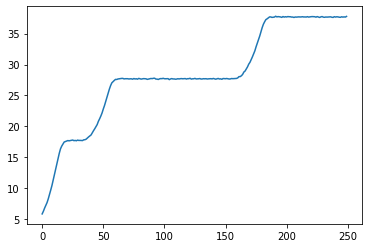

In [6]:
random.seed(3)

fitnessLog, offCounts = run()

plt.plot([mean(gen) for gen in fitnessLog])
plt.show()

In [7]:
START = 0
STOP = 1 +  GENERATIONS


print("Processing raw data...")
print("SELDATA")
sw = 1
SELDATA = [makeSSimage(deserialize(entry),d=KERNEL_SIZE) for entry in offCounts[START:STOP]]

#time average
# SELDATA = [ deserialize(
#     [mean(x) for x in zip(*map(serialize,SELDATA[max(0,i-sw):min(i+sw+1,STOP-START)]))]
# ) for i in range(STOP-START-1)]

# #relative to mean
# seldatamean = mean([mean(serialize(entry)) for entry in SELDATA])
# SELDATA = [np.log2(np.divide(SELDATA[i],seldatamean)) for i in range(STOP-START-1)]


#normalize each frame
seldatamax = [max(serialize(entry)) for entry in SELDATA]
seldatamin = [min(serialize(entry)) for entry in SELDATA]
SELDATA = [np.divide(
    np.subtract(SELDATA[i],seldatamin[i]),seldatamax[i]-seldatamin[i])
           for i in range(STOP-START-1)]

# #normalize each frame
# seldatamax = max([max(serialize(entry)) for entry in SELDATA])
# seldatamin = min([min(serialize(entry)) for entry in SELDATA])
# SELDATA = [np.divide( np.subtract(SELDATA[i],seldatamin),seldatamax-seldatamin) for i in range(STOP-START-1)]


print("DONE")

Processing raw data...
SELDATA
DONE


In [8]:
print("MIXDATA")
K=1+2*KERNEL_SIZE
MIXDATA = [getSS2(entry,K**2) for entry in offCounts[START:STOP]]
mixdatamax= max(MIXDATA)

print("AVEDATA")
AVEDATA = [mean(MIXDATA[max(0,i-10):min(i+10+1,STOP-START)]) for i in range(STOP-START-1)]

print("FITDATA")
fitdatamax = [max(entry) for entry in fitnessLog[START:STOP]]
fitdatamin = [min(entry) for entry in fitnessLog[START:STOP]]

#time average
FITDATA = [np.divide(
    np.subtract(deserialize(fitnessLog[i]),fitdatamin[i]),fitdatamax[i]-fitdatamin[i])
           for i in range(STOP-START-1)]

print("DONE")

MIXDATA
AVEDATA
FITDATA
DONE


In [9]:
FPS = 20
TIME = (STOP-START)//FPS

SAVE = True
SAVENAME = "100pow2_sawtooth_timeave_newSS"


fig = plt.figure(figsize=(6,6))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])


img1 = ax1.imshow(FITDATA[0],vmin=0, vmax=1)#,interpolation="quadric")
img2 = ax2.imshow(SELDATA[0],vmin=0, vmax=1)#, interpolation="quadric")
plt3, = ax3.plot([0],MIXDATA[0],color="k")
plt4, = ax3.plot([0],AVEDATA[0],color="r")

PAD = 10
ax3.set_xlim(START-PAD,STOP-START+PAD)
ax3.set_ylim(0,mixdatamax*1.05)

ax2.set_title("Local SS")
ax3.set_title("Global SS")


# Animation function which updates figure data.  This is called sequentially
def animate(i):
    print("Animating...", int((i*100)/(TIME*FPS)),"%", end ='\r' )
    lri = list(range(i))
    ax1.set_title(i)
    img1.set_array(FITDATA[i])
    img2.set_array(SELDATA[i])
    plt3.set_data(lri,MIXDATA[:i])
    plt4.set_data(lri,AVEDATA[:i])
    return [img1,img2,plt3,plt4]


# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=TIME*FPS, interval=1000/FPS, blit=True)


video = anim.to_html5_video()


if SAVE:
    print("writing animation to disk")
#     anim.save('{}.gif'.format(SAVENAME), writer='ffmpeg')
    with open("{}.html".format(SAVENAME), "w") as f:
        print(video, file=f)

        
plt.close(anim._fig)

# Call function to display the animation
HTML(video)

writing animation to disk
